In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import data_reader
import random

#set precision for displaying float-point values in the notebook
pd.options.display.float_format = '{:,.3f}'.format

#set figure dpi to 100 to get reasonably sized figures displayed in the notebook
plt.rc('figure', dpi=100)

#set savefig dpi to 300 to get high-quality images to insert in the paper
plt.rc('savefig', dpi=300)

#set to 'pdf' or 'eps' for vector figures or to 'png'
plt.rc('savefig', format='png')

#set font sizes for figures throughout
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)

index = ['subj_id', 'session_no', 'block_no', 'trial_no']

In [2]:
dr = data_reader.DataReader()

# if Exp1 and Exp2 data need to be plotted alongside each other, read those data into separate dataframes
exp_1, exp_2 = 'HEM_exp_1', 'HEM_exp_2'
choices_1, dynamics_1, stim_viewing_1 = dr.get_data(path='../../data/%s/processed/' % (exp_1), stim_viewing=True)
choices_2, dynamics_2, stim_viewing_2 = dr.get_data(path='../../data/%s/processed/' % (exp_2), stim_viewing=True)

In [3]:
choices, dynamics, stim_viewing = choices_1, dynamics_1, stim_viewing_1
# choices, dynamics, stim_viewing = choices_2, dynamics_2, stim_viewing_2

In [4]:
dynamics['mouse_v'] = np.sqrt(dynamics.mouse_vx**2 + dynamics.mouse_vy**2 )
choices['early_it'] = stim_viewing.groupby(level=index).apply(
        lambda traj: traj.timestamp.max()-traj.timestamp[traj.mouse_dx==0].iloc[-1])

choices['stim_response'] = choices['early_it'] != 0
choices['early_response'] = choices['initiation_time'] == 0

In [5]:
choices.groupby(['stim_response', 'early_response']).size().unstack()/len(choices)

early_response,False,True
stim_response,,
False,0.853,0.054
True,0.006,0.087


IT_0 is the basic algorithm used so far: look for the first change in mouse coordinate. IT_1 is a generalization of IT_0, looking at the first moment when mouse velocity threshold is crossed. For IT_2, we need to loop over each sample within each trajectory to extract individual submovements.

In [9]:
def get_IT_0(traj):    
    trimmed_traj = traj.drop_duplicates(subset=['mouse_x', 'mouse_y'], keep='last')
    return trimmed_traj.timestamp.min() - traj.timestamp.min()
#     return 0

def get_IT_1(traj): 
    mouse_v_threshold = 50
    return traj.timestamp.iloc[(traj.mouse_v.values>mouse_v_threshold).argmax()]    

def get_IT_2(traj):
    distance_threshold = 50
    v = traj.mouse_v.values

    onsets = []
    offsets = []
    is_previous_v_zero = True

    for i in np.arange(0,len(v)):
        if v[i]!=0:
            if is_previous_v_zero:
                is_previous_v_zero = False
                onsets += [i]
            elif (i==len(v)-1):
                offsets += [i]            
        elif (not is_previous_v_zero):
            offsets += [i]
            is_previous_v_zero = True

    submovements = pd.DataFrame([{'on': onsets[i], 
                     'off': offsets[i], 
                     'on_t': traj.timestamp.values[onsets[i]],
                     'distance':(traj.mouse_v[onsets[i]:offsets[i]]*traj.timestamp.diff()[onsets[i]:offsets[i]]).sum()}
                    for i in range(len(onsets))])

    return submovements.loc[submovements.distance.ge(distance_threshold).idxmax()].on_t

def get_ITs(trajectory):
    IT_0 = get_IT_0(trajectory)
    IT_1 = get_IT_1(trajectory)
    IT_2 = get_IT_2(trajectory)
    return pd.Series({'IT_0': IT_0, 
                      'IT_1': IT_1,
                      'IT_2': IT_2})

choices = choices.join(dynamics.groupby(level=index).apply(get_ITs))

In [ ]:
# ITs = dynamics.groupby(level=index).apply(get_ITs)
# choices['IT_1'] = get_IT_1(dynamics)
# choices['IT_2'] = get_IT_2(dynamics)

# print(len(ITs[abs(ITs.IT_0 - ITs.IT_1)>0.02]))
sns.jointplot(data=choices, x='IT_1', y='IT_2')


# TODO: after that, check correlations between different versions of IT
# For IT_1, look at correlation of IT_1 with IT_0 for each value of threshold

0.086875


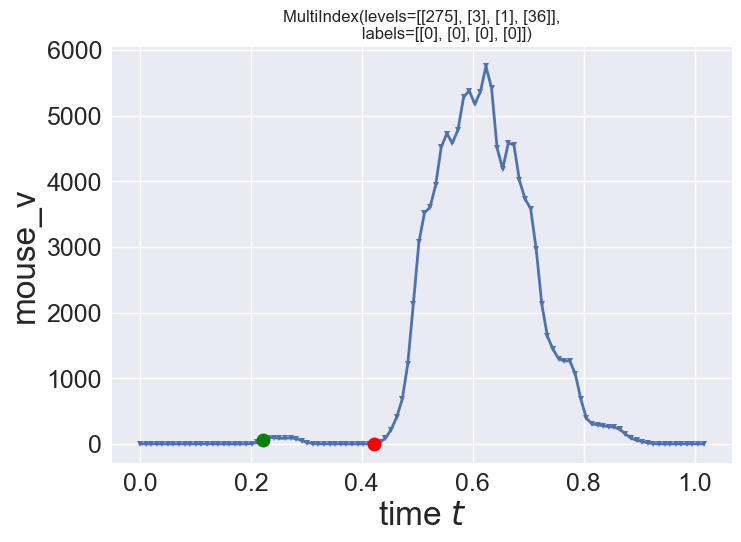

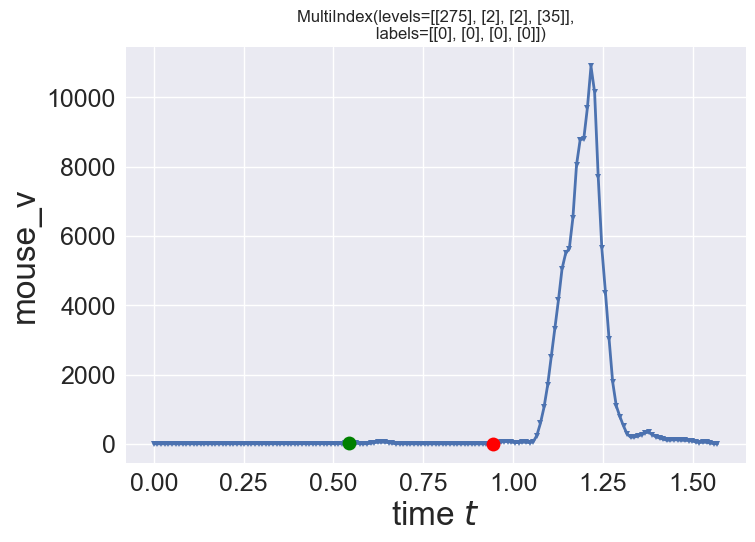

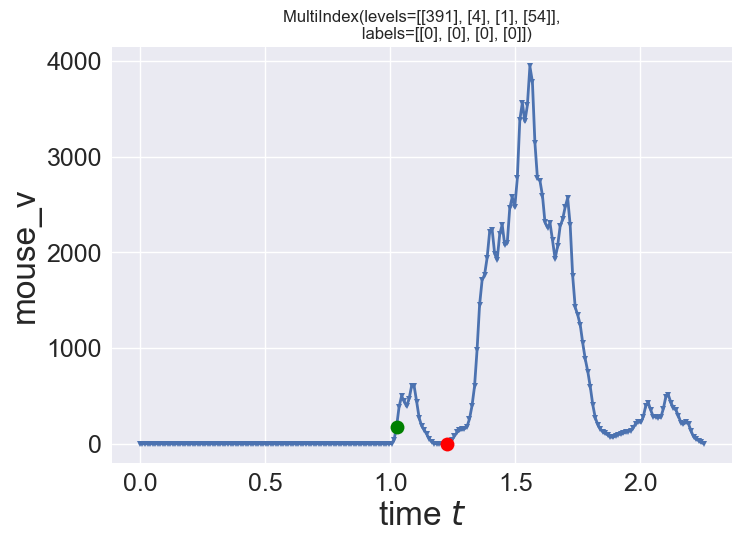

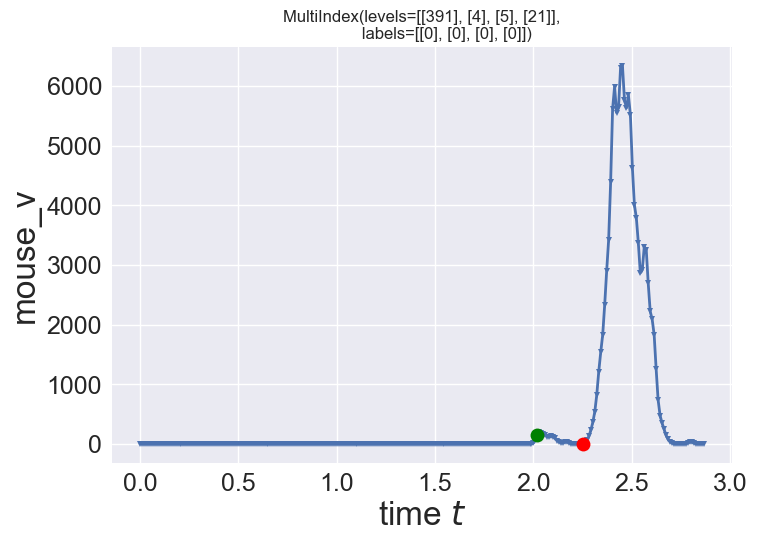

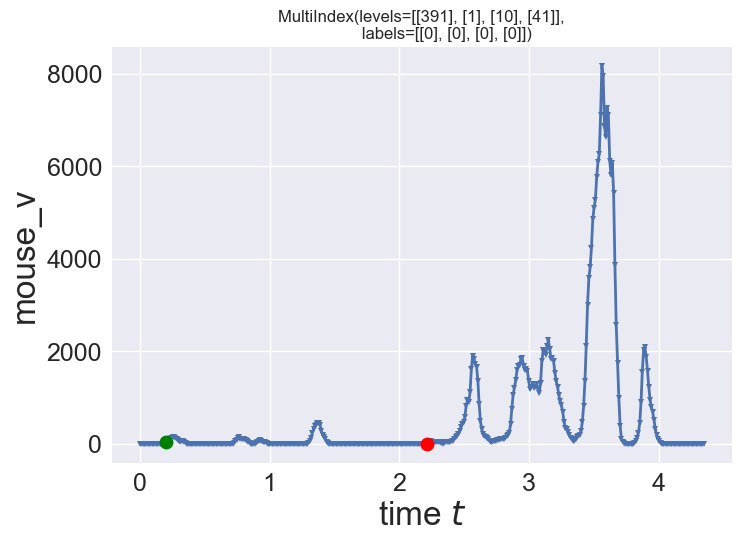

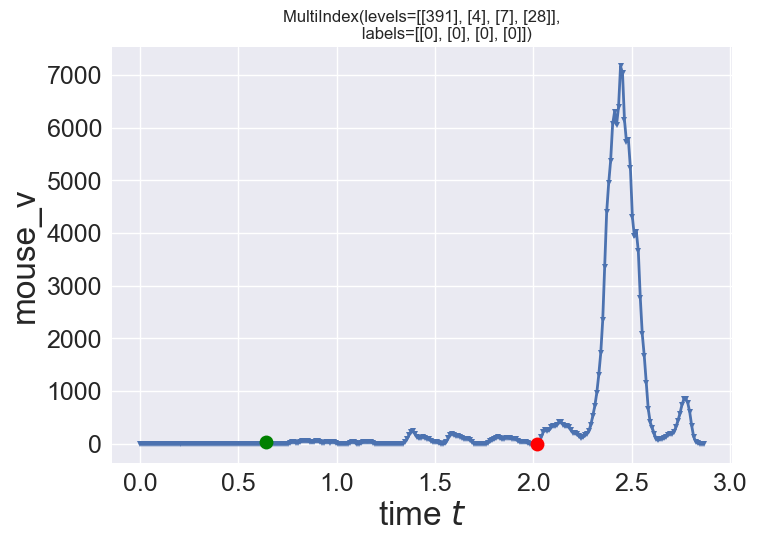

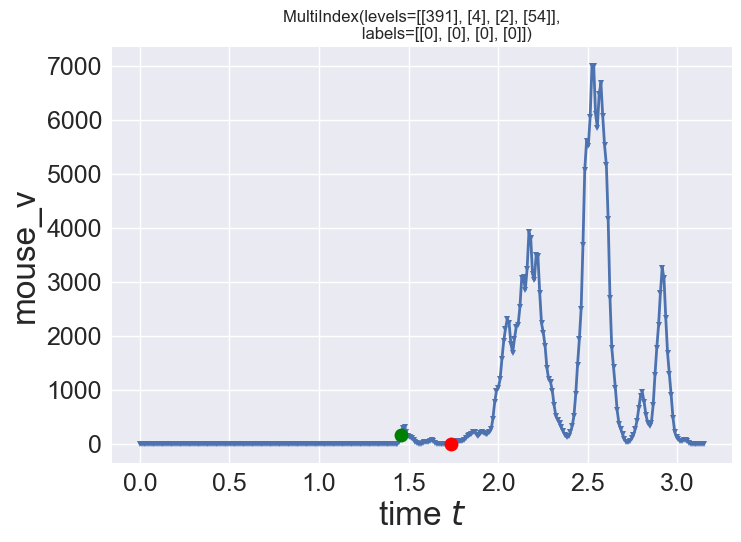

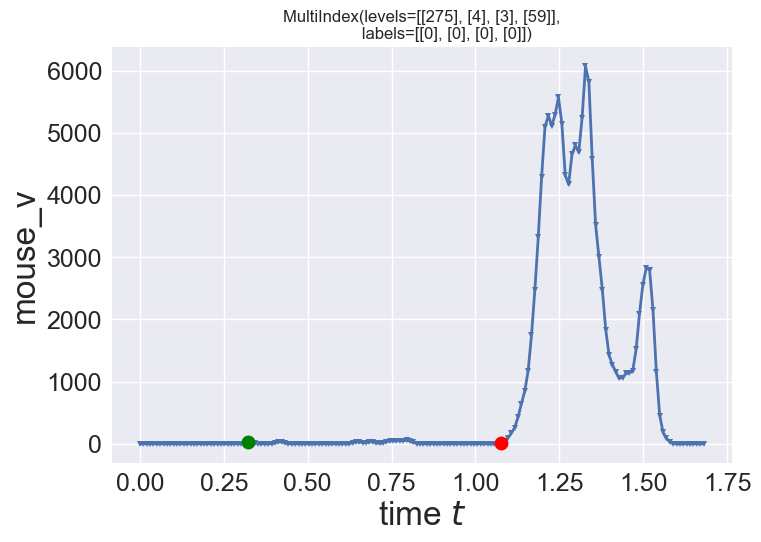

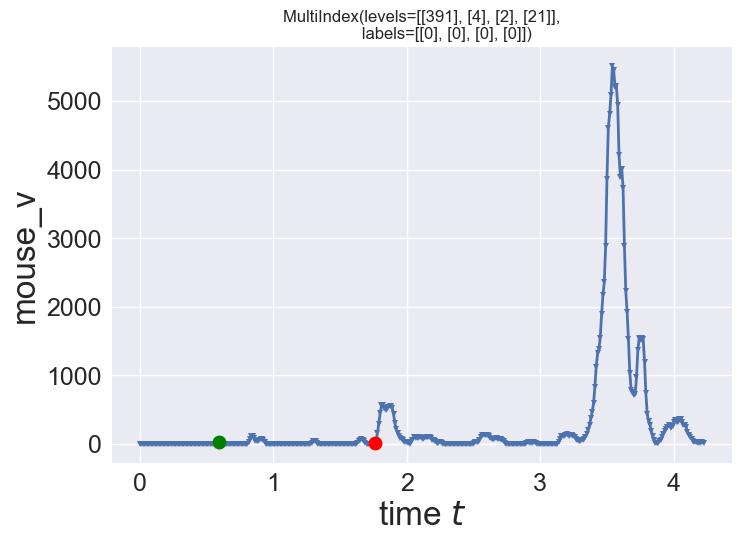

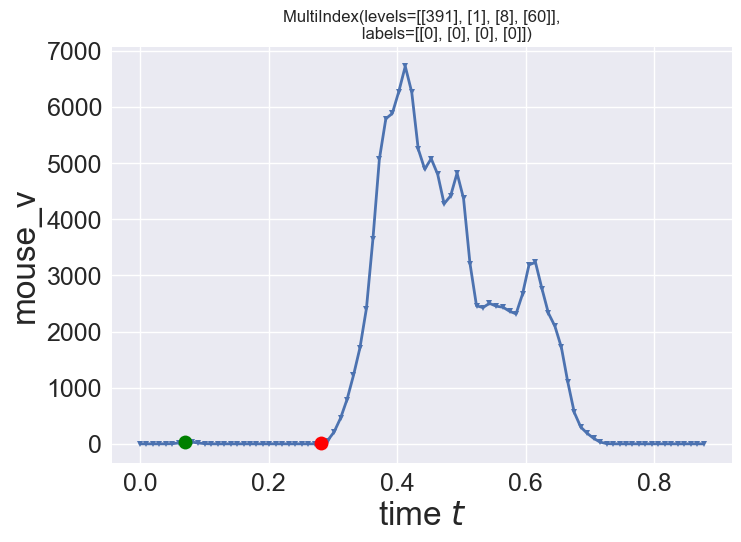

In [11]:
import random
import trajectory_plotter

tp = trajectory_plotter.TrajectoryPlotter()

choices_tmp = choices[abs(choices.IT_0-choices.IT_2)>0.2]
print(len(choices_tmp)/len(choices))

for i in range(1,11):
    trial = random.sample(list(choices_tmp.index), 1)
    choice = choices.loc[trial]
    stim = stim_viewing.loc[trial]
    traj = dynamics.loc[trial]

    it_0 = choice['IT_0'].values[0]
    v_it_0 = traj[traj.timestamp==it_0].mouse_v
    
    it_2 = choice['IT_2'].values[0]
    v_it_2 = traj[traj.timestamp==it_2].mouse_v

    ax = tp.plot_trajectory_var(traj, var='mouse_v')
    ax.plot(it_0, v_it_0, marker='o', ms=10, color='green')
    ax.plot(it_2, v_it_2, marker='o', ms=10, color='red')    
